In [1]:
import torch
import torchvision
import cv2
import copy
import tqdm
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from open3d import JVisualizer
from pcdet.utils.calibration_kitti import get_calib_from_file
from sklearn.preprocessing import LabelEncoder


In [2]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/yzy/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [3]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [4]:
from torchvision.ops import box_iou

le = LabelEncoder()
le.fit(["car", "bicycle", "person"])

def get_prediction(img_path, threshold, filter=['car', 'bicycle', 'person']):
    img = Image.open(img_path) # Load the image
    transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    if torch.cuda.is_available():
        img = img.cuda()
    pred = model([img]) # Pass the image to the model
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold] # Get list of index with score greater than threshold.
    if len(pred_t) == 0:
        return [], [], []
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    if filter is not None:
        filter_index = [i for i in range(len(pred_class)) if pred_class[i] in filter]
        pred_boxes = [pred_boxes[i] for i in filter_index]
        pred_class = [pred_class[i] for i in filter_index]
        pred_score = [pred_score[i] for i in filter_index]

    return pred_boxes, pred_class, pred_score

def create_cyclist(pred_boxes, pred_class, pred_score, iou_threshold=0.3):

    pred_boxes = np.array(pred_boxes).reshape(-1, 4)
    pred_class = np.array(pred_class)
    pred_score = np.array(pred_score)
    pred_class = le.transform(pred_class)
    bicycle_mask = (pred_class == le.transform(["bicycle"])[0])
    person_mask = (pred_class == le.transform(["person"])[0])
    car_mask = (pred_class == le.transform(["car"])[0])
    cars_score = pred_score[car_mask]
    bicycle_score = pred_score[bicycle_mask]
    person_score = pred_score[person_mask]
    cars= pred_boxes[car_mask]
    bicycle_boxes = pred_boxes[bicycle_mask]
    person_boxes = pred_boxes[person_mask]

    # greedy combine from iou
    cyclists, cyclists_score = [], []
    pedestrian_mask = np.ones((person_boxes.shape[0], ), dtype=np.bool)
    if len(bicycle_boxes) > 0 and len(person_boxes) > 0:
        iou = box_iou(torch.tensor(bicycle_boxes), torch.tensor(person_boxes)).cpu().numpy()
        max_iou = np.max(iou.reshape(1, -1))
        num_bicycle, num_person = iou.shape
        while max_iou > iou_threshold:
            max_iou_idx = np.argmax(iou.reshape(1, -1))
            idx_bicycle = int(max_iou_idx // num_person)
            idx_person = int(max_iou_idx % num_person)
            pedestrian_mask[idx_person] = False
            cyclist = [min(bicycle_boxes[idx_bicycle, 0], person_boxes[idx_person, 0]),
                       min(bicycle_boxes[idx_bicycle, 1], person_boxes[idx_person, 1]),
                       max(bicycle_boxes[idx_bicycle, 2], person_boxes[idx_person, 2]),
                       max(bicycle_boxes[idx_bicycle, 3], person_boxes[idx_person, 3])]
            cyclists.append(cyclist)
            cyclists_score.append((bicycle_score[idx_bicycle]+person_score[idx_person])*0.5)
            iou[:, idx_person] = 0
            iou[idx_bicycle, :] = 0
            max_iou = np.max(iou.reshape(1, -1))
    cyclists = np.array(cyclists).reshape(-1, 4)
    pedestrians = person_boxes[pedestrian_mask]
    pedestrians_score = person_score[pedestrian_mask]
    pred_boxes = np.concatenate([cars, cyclists, pedestrians])
    pred_score = np.concatenate([cars_score, cyclists_score, pedestrians_score])
    pred_class = ["car"] * len(cars) + ["cyclist"] * len(cyclists) + ["pedestrian"] * len(pedestrians)
    return pred_boxes, pred_class, pred_score

In [7]:
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):

    boxes, pred_cls, pred_score = get_prediction(img_path, threshold) # Get predictions
    boxes, pred_cls, pred_score = create_cyclist(boxes, pred_cls, pred_score)
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0]), int(boxes[i][1])), (int(boxes[i][2]), int(boxes[i][3])), color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img, pred_cls[i], (int(boxes[i][0]), int(boxes[i][1])),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
        # cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
        # cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
    plt.figure(figsize=(20,30)) # display the output image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

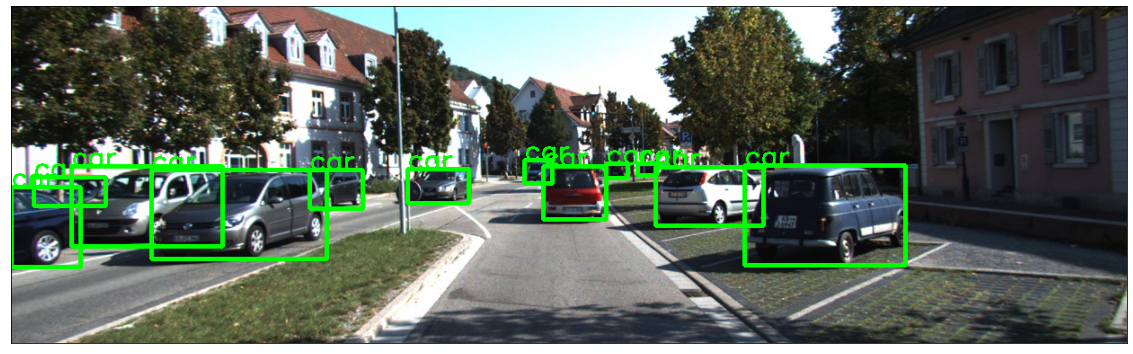

In [8]:
object_detection_api("test_file.jpg", threshold=0.5, text_size=1, text_th=2)

In [215]:
# create prediction
num_image = 7481
image_dir = "/home/yzy/PycharmProjects/OpenPCDet/data/kitti/training/image_2/"
pred_dir = "/home/yzy/PycharmProjects/OpenPCDet/data/kitti/training/image_2_pred/"
for i in tqdm.trange(num_image):
    img_path = image_dir + "%06d.png" % i
    boxes, pred_cls, score = get_prediction(img_path, 0.5) # Get predictions
    boxes, pred_cls, score = create_cyclist(boxes, pred_cls, score)
    with open(pred_dir+"%06d.txt" % i, 'w') as f:
        for idx in range(len(boxes)):
            f.write("%s %d %d %d %f %f %f %f %f" % (pred_cls[idx], 0, 0, -10,
                                                    boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3],
                                                    score[idx]))
            if idx != len(boxes-1):
                f.write('\n')


100%|██████████| 7481/7481 [04:45<00:00, 26.23it/s]
